# Projet Data Science - Livrable 2
## Code du programme
Avant toute chose, il est nécessaire d'importer les différentes bibliothèques qui seront utilisées par le programme.

In [1]:
import scipy
from scipy import ndimage
import numpy as np
import imageio
import matplotlib.pyplot as plt
import cv2 as cv
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Suite à cela, on procède à la création des datasets depuis les fichiers. Les paramètres choisies pour les datasets sont les suivants:
- Des images de dimensions 96px
- Des batches de taille 50

Ces valeurs ont été choisies à la fois de manière empirique, en constatant qu'elles permettaient d'obtenir de bons résultats, mais aussi car d'après nos recherches il s'agit de valeurs classiques pour ce cas de figure (les tailles d'image étant souvent de 32/96/128px et les batches de 32/64/100). Le dataset d'entrainement, quant à lui, représente 80% des données disponibles.

Détail ayant son importance, dans le fichier contenant le dataset, nous avons réorganisé les fichiers pour qu'il n'y ait que deux classes : une classe "Photo" et une classe "Other" contenant les peintures, textes, schémas et dessins, ce qui permettra d'obtenir de meilleurs résultats.

In [2]:
main_path = "D:/dataset livrable 2/"

validation_split= 0.2
labels = 'inferred'
label_mode = 'int'
seed = 42
img_height = 96
img_width = 96
batch_size = 50

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    main_path,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    main_path,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 41406 files belonging to 2 classes.
Using 33125 files for training.
Found 41406 files belonging to 2 classes.
Using 8281 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

On peut ensuite définir le modèle du réseau de neurones:

In [3]:
num_classes = 2

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

def create_model():
    model = Sequential([
        #data_augmentation,
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.6),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model
    
model = create_model()

Ce réseau de neurones est ainsi composé de 13 couches, dont 4 couches de convolution. Une couche de dropout est également présente avant l'applanissement, afin de réduire le sur-apprentissage du réseau. Une couche d'augmentation des données a été testée puis abandonnée, pour des raisons qui seront explicitées plus bas.

Pour ce qui est de l'optimisation et de la fonction de perte, nous avons choisi les standards que sont Adam et Sparse Categorical Cross Entropy. Quelques essais avec d'autres algorithmes d'optimisation (Nadam, Adagrad, ...) nous ont montrés que si les calculs pouvaient éventuellement être plus rapides, les performances du réseau étaient négativement affectées (perte de précision de 5 à 10%).<br/>
Nous avons donc choisi de rester avec cette optimisation et cette fonction de perte, afin de nous consacrer davantage à l'affinage des paramètres.

Le réseau peut être représenté ainsi:

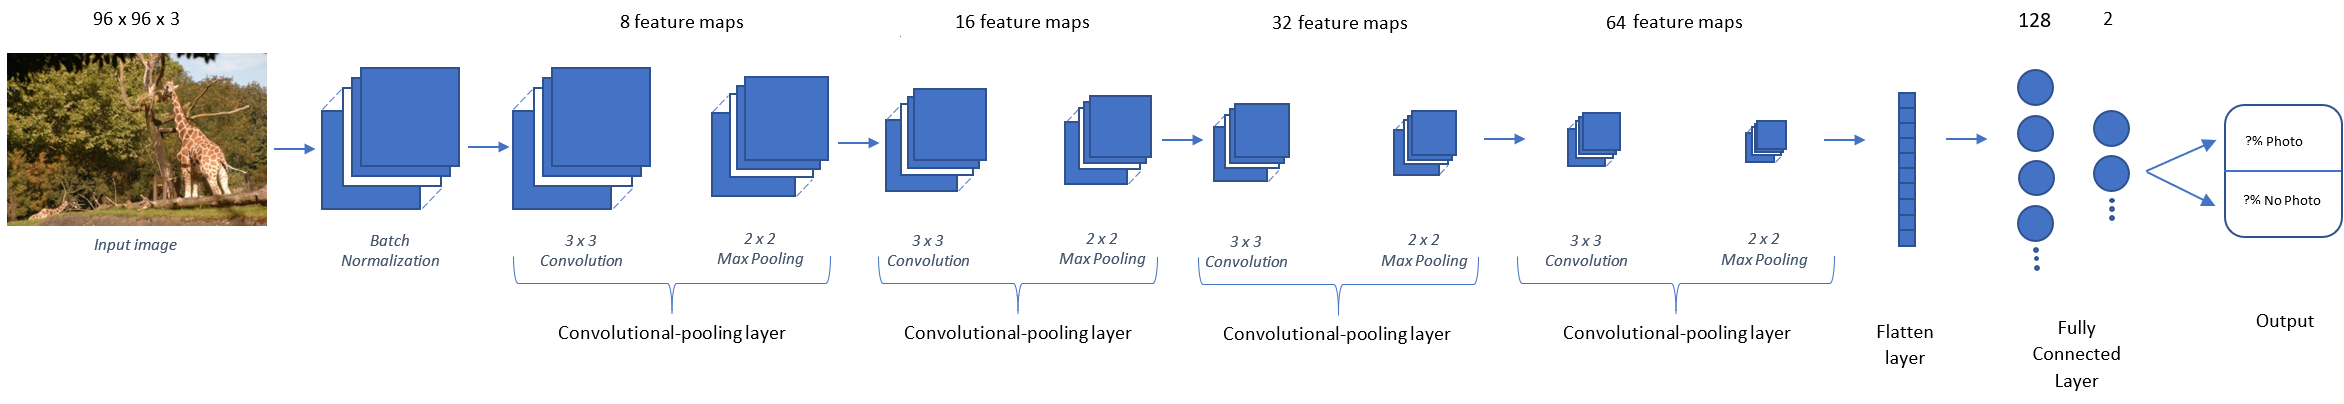

Puis on peut entrainer le réseau (sur 20 epochs, afin de prévenir l'overfitting grâce à une stratégie d'early-stopping, ce qui sera expliqué plus en profondeur ci-dessous):

In [4]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
663/663 [==============================] - 302s 452ms/step - loss: 0.3998 - accuracy: 0.7847 - val_loss: 0.2936 - val_accuracy: 0.8564
Epoch 2/10
663/663 [==============================] - 246s 368ms/step - loss: 0.2994 - accuracy: 0.8561 - val_loss: 0.2528 - val_accuracy: 0.8831
Epoch 3/10
663/663 [==============================] - 247s 370ms/step - loss: 0.2573 - accuracy: 0.8838 - val_loss: 0.2422 - val_accuracy: 0.8905
Epoch 4/10
663/663 [==============================] - 502s 754ms/step - loss: 0.2376 - accuracy: 0.8975 - val_loss: 0.2203 - val_accuracy: 0.9035
Epoch 5/10
663/663 [==============================] - 1033s 2s/step - loss: 0.2231 - accuracy: 0.9047 - val_loss: 0.2361 - val_accuracy: 0.9050
Epoch 6/10
663/663 [==============================] - 713s 1s/step - loss: 0.2063 - accuracy: 0.9117 - val_loss: 0.2395 - val_accuracy: 0.8936
Epoch 7/10
663/663 [==============================] - 329s 487ms/step - loss: 0.1924 - accuracy: 0.9171 - val_loss: 0.1905 - val_

Afin de ne pas gaspiller le temps mis à calculer les poids, il est intéressant de sauvegarder et de pouvoir restaurer le modèle suite à l'entrainement:

In [ ]:
# Enregistrement du modèle
model.save_weights('saved models/norm_yes-dropout0.6-batch_100-pix_96-epoch20-Matrix_8-16-32-64-class_2')

In [ ]:
# Restauration du modèle
model = create_model()
model.load_weights('saved models/norm_yes-dropout0.6-batch_100-pix_96-epoch20-Matrix_8-16-32-64-class_2')

Les résultats de l'entrainement peuvent être affichés en exécutant le code suivant:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Pour tester l'efficacité du réseau, on peut alors effectuer des prédictions soit sur le dataset de validation, soit sur des images stockées sur le disque:

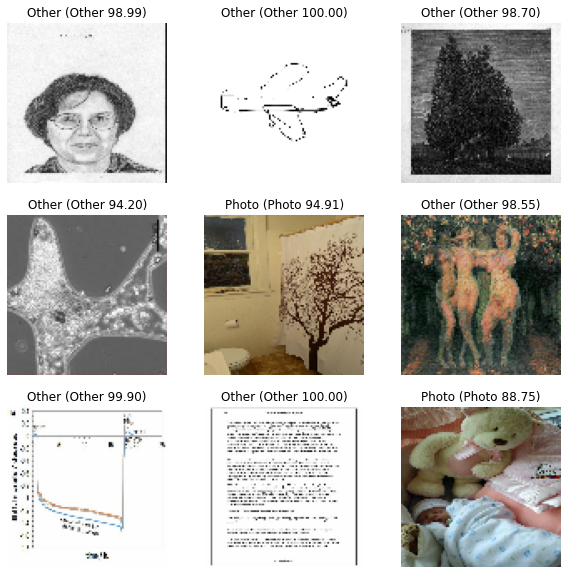

In [8]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    img_array = keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]] + " ({} {:.2f})".format(class_names[np.argmax(score)], 100 * np.max(score)))
    plt.axis("off")

This image most likely belongs to Other with a 97.12 percent confidence.


(-0.5, 95.5, 95.5, -0.5)

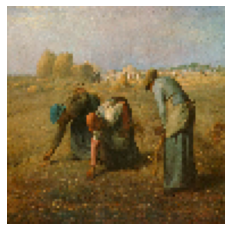

In [7]:
test_path = "C:/Jupyter/validation/jean-francois-millet.-les-glaneuses-1857-.jpg"

img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

plt.imshow(img)
plt.axis('off')

## Analyse des résultats

Ci-dessous, le graphique de résultat de l'entrainement du réseau de neurones avec les paramètres ci-dessus (et en classifiant les fichiers dans deux classes) :

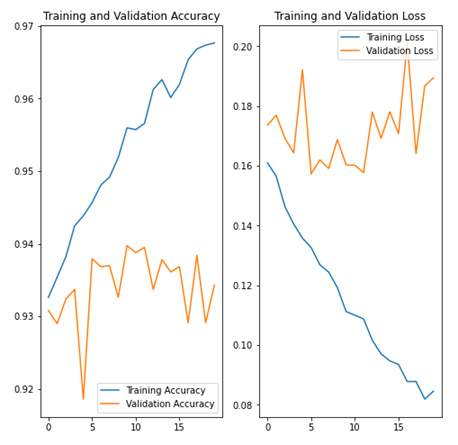

Le fait d'avoir seulement 2 classes améliore la performance du réseau de neurones. En effet, à paramètres égaux (taille de 96px, batches de 50, dropout à 0.6, 3 couches de convolution) on observe une différence selon que l'on classifie en 2 ou 5 classes :

<table height="50%">
    <tr>
        <td text-align="center">2 classes</td>
        <td text-align="center">5 classes</td>
    </tr>
    <tr>
        <td>
            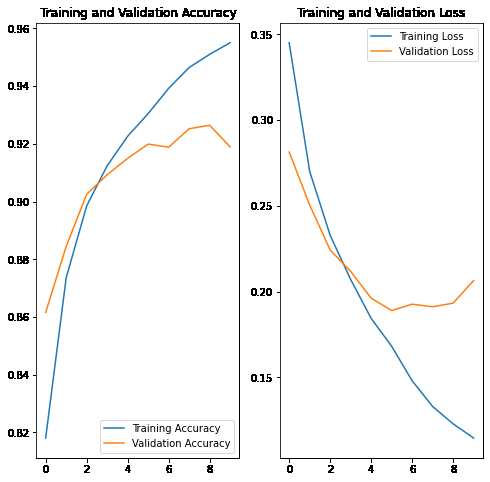
        </td>
        <td>
            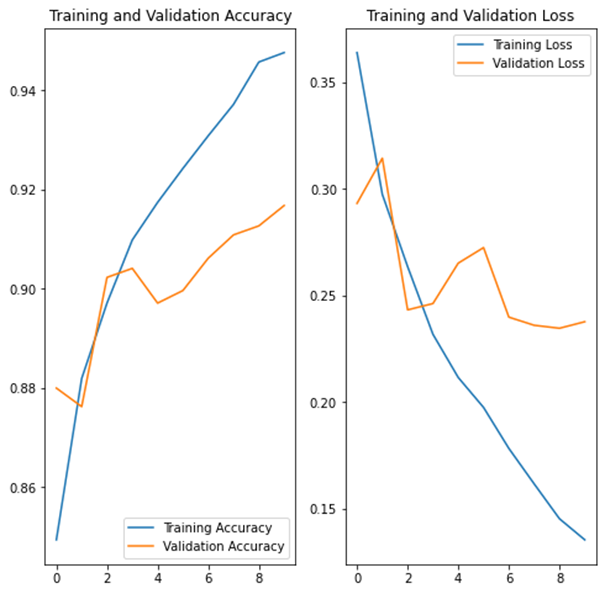
        </td>
    </tr>
</table>

Comme on peut le voir sur le 1er graphique, les paramètres choisis permettent d’obtenir un modèle qui ne souffre pas vraiment de sur-apprentissage, notamment grâce à la présence du dropout, puisqu'un entrainement du réseau sans aucun dropout produira le résultat suivant, où le sur-apprentissage est évident : 

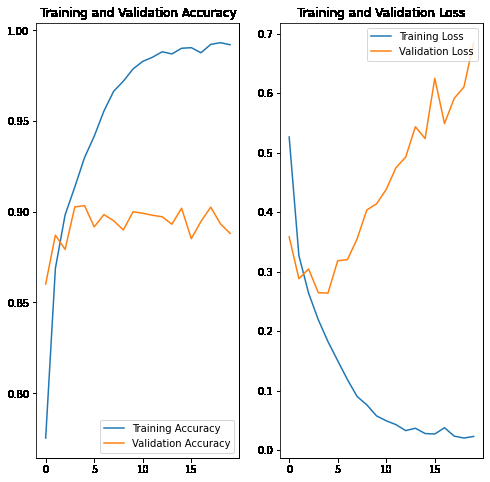

Toutefois, le nombre relativement faible d’époques peut faire craindre un sous-apprentissage. Néanmoins, ce nombre faible a été choisi à dessein, puisqu’il est issu d’une stratégie d’early stopping. Le sur-apprentissage commence à se manifester clairement à partir de 20 époques, alors que le modèle à déjà atteint une précision quasi-maximale. Nous avons donc choisi de stopper le modèle à 20 époques, puisque cela représentait le meilleur compromis entre le biais et la variance.

Afin d’améliorer le modèle, nous avons expérimenté des techniques d’augmentation de données, cependant il nous a fallu remarquer qu’utiliser ces techniques ne faisaient que diminuer la qualité des résultats obtenus. Exemple ici avec deux modèles avec un dropout à 0.2, des images de 64px et des batches de 100, mais une augmentation que dans le second modèle :

<table height="50%">
    <tr>
        <td text-align="center">Sans augmentation</td>
        <td text-align="center">Avec augmentation</td>
    </tr>
    <tr>
        <td>
            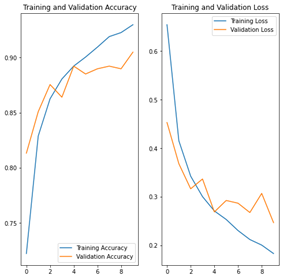
        </td>
        <td>
            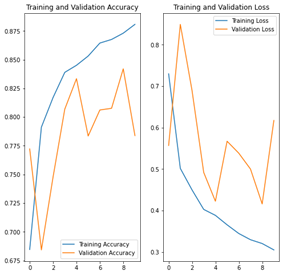
        </td>
    </tr>
</table>

On constate ainsi que l’augmentation, au-delà de rajouter du bruit dans les résultats, a également diminué les valeurs atteintes précédemment.